In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

random.seed(3)

#返回单次是否成功
def box_game_success(strategy, box_count=100, choice_count=50, day_count=1):

    def once_play_success():
        for i in range(day_count):
            if is_oneday_success():
                return True
        return False

    def is_oneday_success():
        return strategy(box_count, choice_count)

    return once_play_success()


def cyclical_strategy(box_count, choice_count):
    boxes = list(range(box_count))
    random.shuffle(boxes)
    success_people_nums = 0

    for person in range(box_count):
        choice = person
        for _ in range(choice_count):
            if boxes[choice] == person:
                success_people_nums += 1
                break
            else:
                choice = boxes[choice]

    return success_people_nums == box_count


def random_strategy(box_count, choice_count):
    boxes = list(range(box_count))
    random.shuffle(boxes)
    success_people_nums = 0

    choice_list = list(range(choice_count))
    random.shuffle(choice_list)
    for person in range(box_count):
        for i in range(choice_count):
            choice = choice_list[i]
            if boxes[choice] == person:
                success_people_nums += 1
                break

    return success_people_nums == box_count

In [2]:
def success_rate(num_of_times, strategy, box_count=100, choice_count=50, day_count=1):
    success_times = 0
    for i in range(num_of_times):
        if box_game_success(strategy, box_count, choice_count, day_count):
            success_times += 1

    rate = success_times / num_of_times
    return rate


def time_till_success(strategy, box_count=100, choice_count=50, day_count=1):
    time_passed = 1
    while not box_game_success(strategy, box_count, choice_count, day_count):
        time_passed += 1
    return time_passed

In [3]:
success_rate(10000, cyclical_strategy)

0.3223

In [4]:
success_rate(10000, random_strategy)

0.0

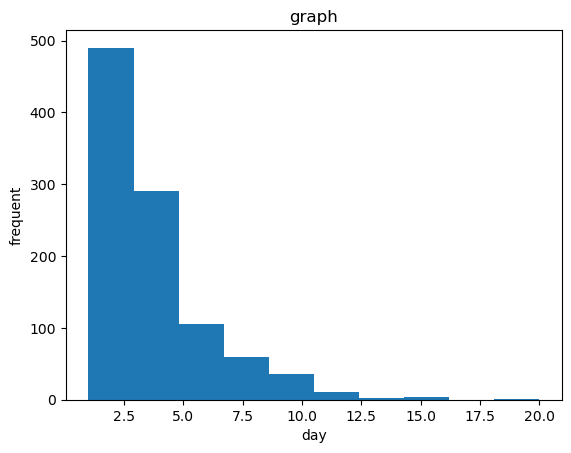

In [5]:
# 统计循环策略中一直尝试直到成功的时间
stats_time = 1000
time_data = [time_till_success(cyclical_strategy) for _ in range(stats_time)]
plt.hist(time_data)
plt.title('graph')
plt.xlabel('day')
plt.ylabel('frequent')
plt.show()

In [6]:
# 针对大规模的模拟，进行向量化
def box_game_vectorized(num_prisoners=100, max_attempts=50, num_simulations=10000):

    # 初始化所有模拟批次的盒子
    # 创建一个 (num_simulations, num_prisoners) 形状的数组
    boxes = np.argsort(np.random.rand(num_simulations, num_prisoners), axis=1)

    # 初始时，每个囚犯从自己的编号对应的盒子开始查找 (0-indexed)
    # current_box_indices 形状: (num_simulations, num_prisoners)
    current_box_indices = np.tile(np.arange(num_prisoners), (num_simulations, 1))

    # 记录每个模拟批次中每个囚犯是否已找到自己的编号
    # found_self 形状: (num_simulations, num_prisoners)
    found_self = np.zeros((num_simulations, num_prisoners), dtype=bool)

    # 循环进行查找，直到所有囚犯在某个批次中都找到或者达到最大尝试次数
    for attempt in range(max_attempts):

        # 根据当前盒子索引获取盒子里面的纸条编号
        # next_box_indices 形状: (num_simulations, num_prisoners)
        next_box_indices = np.take_along_axis(boxes, current_box_indices, axis=1)

        # 检查哪些囚犯在当前步骤找到了自己的编号
        # found_current_step 形状: (num_simulations, num_prisoners)
        found_current_step = (next_box_indices == np.arange(num_prisoners))

        # 更新 found_self
        found_self = found_self | found_current_step

        # 更新 current_box_indices
        # 只有那些还没找到自己的囚犯才需要更新他们的下一个查看的盒子
        current_box_indices = np.where(found_self, current_box_indices, next_box_indices)

    # 判断每个模拟批次是否成功：该批次中的所有囚犯都找到了自己的编号
    # successes_per_simulation 形状: (num_simulations,)
    successes_per_simulation = np.all(found_self, axis=1)

    # 计算成功批次的数量
    success_count = np.sum(successes_per_simulation)

    return success_count / num_simulations


num_prisoners = 100
max_attempts = 50
num_simulations = 100000

print(f"完全向量化模拟 {num_simulations} 次，囚犯 {num_prisoners} 人，最大尝试 {max_attempts} 次。")
probability = box_game_vectorized(num_prisoners, max_attempts, num_simulations)
print(f"成功获释的概率：{probability:.4f}")

完全向量化模拟 100000 次，囚犯 100 人，最大尝试 50 次。
成功获释的概率：0.3119


In [7]:
# 不同的囚犯数和尝试次数
print(success_rate(10000, cyclical_strategy, 50, 25))
print(success_rate(10000, cyclical_strategy, 200, 100))

0.3226
0.3141


## 成功概率的计算

问题可转化为：在一个随机排列中，最长循环的长度不超过 $N/2$ 的概率是多少？ （其中 $N=100$）

这个概率的计算涉及排列理论。对于一个包含 $N$ 个元素的排列，其中最长循环长度超过 $N/2$ 的情况，只可能存在一个这样的长循环。如果存在一个长度为 $k$ 的循环 ($k > N/2$)，那么这个排列就失败了。

失败的概率是所有可能存在的最长循环长度 $k$ 超过 $N/2$ 的概率之和。
$P(\text{失败}) = P(L=51) + P(L=52) + \dots + P(L=100)$

对于一个 $N$ 元素的随机排列，出现一个长度为 $k$ 的循环的概率是 $1/k$。
因此，失败的概率可以近似表示为：
$P(\text{失败}) \approx \sum_{k=N/2 + 1}^{N} \frac{1}{k}$
$P(\text{失败}) = \frac{1}{51} + \frac{1}{52} + \dots + \frac{1}{100}$

这个求和被称为调和级数的一部分。
$\sum_{k=51}^{100} \frac{1}{k} \approx \ln(100) - \ln(50) = \ln(2) \approx 0.693$

因此，成功的概率 $P(\text{成功}) = 1 - P(\text{失败})$
$P(\text{成功}) \approx 1 - \ln(2) \approx 1 - 0.693 = 0.307$

这意味着，通过采用这种链式追踪策略，囚犯们集体获释的概率大约是 30.7%。